# Smooth electron hole

In [109]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize as op
import plasmapy
from scipy import special as sp
from scipy import integrate
from tqdm import tqdm
import numba as nb
import math
import matplotlib.cm as cm
from prettytable import PrettyTable
from scipy.optimize import curve_fit
%config InlineBackend.figure_format = 'svg'

In [110]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})

In [111]:
T = 1
# k = 0.1
# L = 2*np.pi/k
L = 100
u = 1.25

vmax = 10 # 速度最大值
nx = 500
nv = 1000
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
V,X=np.meshgrid(v,x)

c1 = 0
c2 = 0

dt = 0.02
max_steps  = 10000
data_steps = max_steps
data_num = int(max_steps/data_steps)+1

path = 'E:/代码/vlasov-es1d/data/'

## smooth-EH分布
$$ f_u(w>0) = \frac{1}{2\sqrt{2\pi}} \left[ e^{-\frac{(\sqrt{2w}+u)^2}{2}} + e^{-\frac{(\sqrt{2w}-u)^2}{2}} \right] $$
$$ f_t(w<0) = \frac{1}{\sqrt{2\pi}} e^{-w-\frac{u^2}{2}} \cos(\sqrt{-2w}u) $$
其中$w=v^2/2-\phi$

In [112]:
@nb.jit
def nonvec_f_sm(v,phi):
    r = 0
    w = (v**2)/2-phi
    if w>0:
        r = math.exp(-0.5*((2*w)**0.5+u)**2) + math.exp(-0.5*((2*w)**0.5-u)**2)  
    else:
        r = math.exp(-w-u**2/2)*math.cos((-2*w)**0.5*u)*2
    return r/(2*np.pi)**0.5/2
f_sm = np.vectorize(nonvec_f_sm)

In [113]:
xi = u/np.sqrt(2)
B = 1 + xi/2*plasmapy.dispersion.plasma_dispersion_func(xi).real - xi/2*plasmapy.dispersion.plasma_dispersion_func(-xi).real
D = ((3-u**2)*B-1)/4
del_x = 2/np.sqrt(B)
psi = -1.5*B/D
phi_sc = 0.7*psi*np.cosh((x-L/2)/del_x)**(-2)

In [114]:
print(del_x,psi)
print(psi*u**2,np.pi**2/8)

9.412658635299403 0.289686639328943
0.45263537395147346 1.2337005501361697


In [115]:
for count in tqdm(range(10)):
    V,Phi_sc=np.meshgrid(v,phi_sc)
    f_matrix = f_sm(V,Phi_sc)
    n_sc = f_matrix.sum(axis=1)*dv
    
    dx2 = dx*dx
    laplace = -2.0*np.eye(nx-2,k=0)+np.eye(nx-2,k=1)+np.eye(nx-2,k=-1)
    
#     # natural BC
#     laplace[0][0]=-1
#     laplace[-1][-1]=-1
    
    r = (1.0 - n_sc[1:nx-1])*dx2 + np.dot(laplace,phi_sc[1:nx-1])
    
    # Dirichlet BC phi[0]=c1 phi[-1]=c2
    r[0]  += c1
    r[-1] += c2
    
    m = 2.0 + (n_sc[2:nx]-n_sc[0:nx-2])/(phi_sc[2:nx]-phi_sc[0:nx-2])*dx2
    nr_mat = np.diag(m) - np.eye(nx-2,k=1) - np.eye(nx-2,k=-1)
    dphi = np.linalg.solve(nr_mat,r)
    phi_sc[1:nx-1] += dphi
    
    err = ((dphi/phi_sc[1:nx-1])**2).sum()
    if err<= 1e-6:
        print("Sucess! Iteration counts =", count)
#         print("err =", err)
        break
print(err)

 40%|██████████████████████████████████████████████████████                                                                                 | 4/10 [00:00<00:01,  4.62it/s]

Sucess! Iteration counts = 4
1.788728871250768e-11


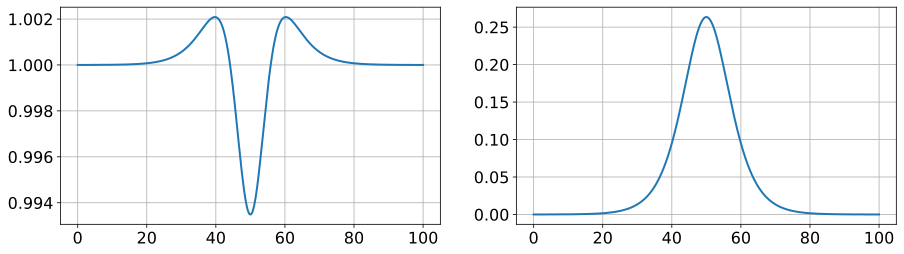

In [116]:
fig = plt.figure(figsize=(15,4))
ax1 = plt.subplot(121)
ax1.plot(x,n_sc)
ax1.grid()
ax3 = plt.subplot(122)
ax3.plot(x,phi_sc)
ax3.grid()
# ax3.set_xlim(0.3*L,0.7*L)
# ax3.set_yscale('log')
plt.show()

In [117]:
xc = L/2
def phi2_theo(x,a,da):
    xp = (x-xc)/da
    return a*np.cosh(xp)**(-2)
para2,pcov=curve_fit(phi2_theo,x,phi_sc)
print(para2)

[0.26261065 9.13703911]


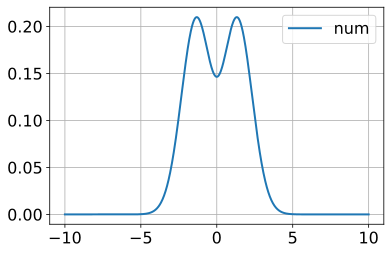

In [118]:
V,Phi_sc=np.meshgrid(v,phi_sc)
f_sm_matrix = f_sm(V,Phi_sc)
plt.plot(v,f_sm_matrix[int(nx/2),],label='num')
plt.legend()
# plt.ylim(0.05,0.31)
plt.grid()

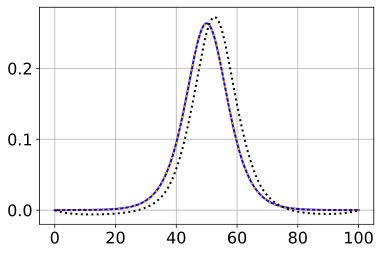

In [134]:
plt.plot(x,phi_sc,color='blue')
plt.plot(x,phi2_theo(x,para2[0],para2[1]),linestyle=':',color='orange')
plt.plot(x,phi[1],linestyle=':',color='black')
plt.grid()
#plt.xlim(20,40)
plt.show()

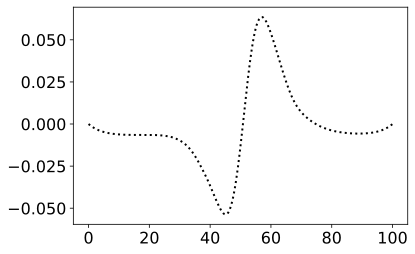

In [120]:
plt.plot(x,phi[1]-phi_sc,linestyle=':',color='black')

In [121]:
progesses = np.arange(0,data_num,1)

fe = []
fi = []
phi = []

for progess in progesses:
    fe_temp = np.loadtxt(os.path.join(path,"fe"+str(progess)))
    fe.append(fe_temp)
    fi_temp = np.loadtxt(os.path.join(path,"fi"+str(progess)))
    fi.append(fi_temp)
    phi_temp = np.loadtxt(os.path.join(path,"phi"+str(progess)))
    phi.append(phi_temp)

In [122]:
fx0 = np.sum(fe[0],axis=1)*dv
fv0 = np.sum(fe[0],axis=0)*dx/L

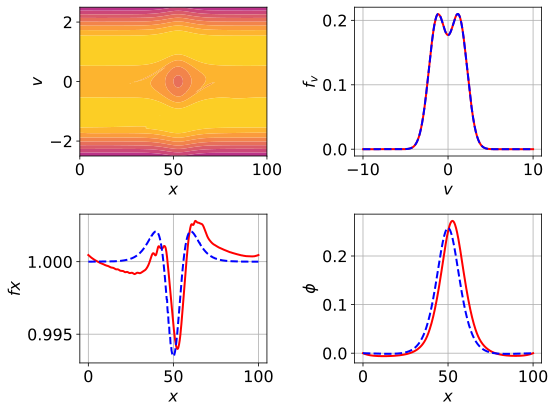

In [123]:
fig = plt.figure(figsize=(8, 6))

test_frame = 1
fx = np.sum(fe[test_frame],axis=1)*dv
fv = np.sum(fe[test_frame],axis=0)*dx/L
lvs_idx = np.linspace(-10,1,num=50)
lvs = 10**lvs_idx

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1cm = ax1.contourf(X, V, fe[test_frame], levels=20,cmap=cm.plasma)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$v$')
ax1.set_ylim(-2.5,2.5)

ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2.plot(v, fv, color='red')
ax2.plot(v, fv0,'--', color='blue')
ax2.set_xlabel(r'$v$')
ax2.set_ylabel(r'$f_{v}$')
ax2.grid()

ax3 = plt.subplot2grid((2, 2), (1, 0))
ax3.plot(x, fx, color='red')
ax3.plot(x, fx0,'--', color='blue')
ax2.set_xlabel(r'$v$')
ax3.set_xlabel(r'$x$')
ax3.set_ylabel(r'$fx$')
ax3.grid()

ax4 = plt.subplot2grid((2, 2), (1, 1))
ax4.plot(x, phi[test_frame], color='red')
ax4.plot(x, phi[0],'--', color='blue')
ax4.set_xlabel(r'$x$')
ax4.set_ylabel(r'$\phi$')
ax4.grid()

plt.tight_layout()

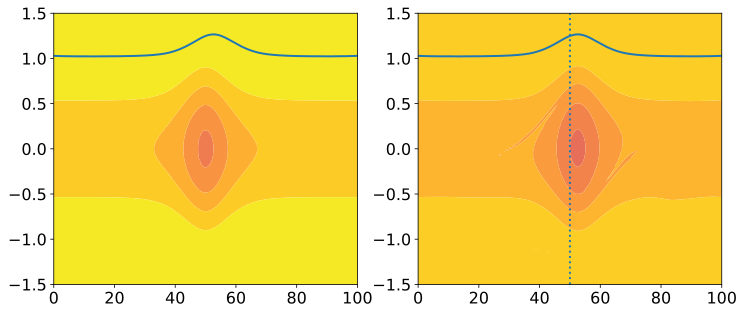

In [124]:
ux = np.sqrt(u**2-2*phi[1][250]+2*phi[1])
testx=250
fig = plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
plt.contourf(X, V, fe[0], levels=15, cmap=cm.plasma)
plt.plot(x,ux)
plt.ylim(-1.5,1.5)

ax2 = plt.subplot(122)
plt.contourf(X, V, fe[test_frame], levels=15, cmap=cm.plasma)
plt.plot(x,ux)
plt.axvline(testx/nx*L,linestyle=':')
# plt.xlim(0.25*L,0.75*L)
plt.ylim(-1.5,1.5)
plt.show()

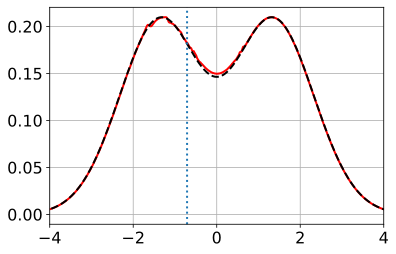

In [135]:
# plt.plot(v,fe[0][testx],color='blue')
plt.plot(v,fe[1][testx],color='red')
plt.plot(v,f_sm_matrix[testx,],linestyle='--',color='black')
plt.axvline(-np.sqrt(2*phi[1][testx]),linestyle=':')
# plt.yscale('log')
plt.xlim(-4,4)
plt.grid()
plt.show()